In [1]:

from plantcv import plantcv as pcv 
# import analyze_area
import cv2
from matplotlib import pyplot as plt
import numpy as np
import cluster_jordan 
import math

# set to "plot" to see image at every step (takes longer)
class options:
    def __init__(self):
        self.image = "./img/original_image.jpg"
        self.debug = "plot"
        self.writeimg= False
        self.result = "vis_tutorial_results.json"
        self.outdir = "." # Store the output to the current directory
        
# Get options
args = options()

# Set debug to the global parameter 
pcv.params.debug = args.debug
#sets the size of the debug images. Smaller values will run faster. A larger value was chosen for demonstration
pcv.params.dpi=200

In [2]:
#Load the image
imagelink = f"./test_images/plate_as_scale/p6.jpg"
image = cv2.imread(imagelink)


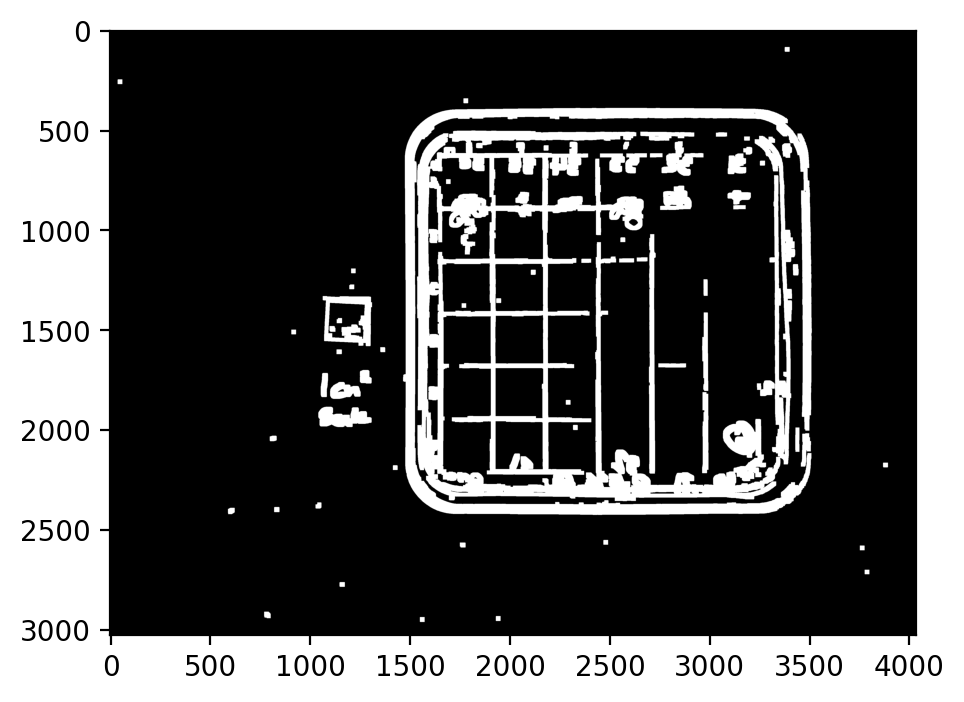

In [3]:
#edge detection - the goal here is to detect the plate and have the contour around the plate be as complete as possible
#some noise is ok at the step because we will filter it out using erosion and dilation, small gaps around the plate edge are also ok but large gaps are not
#the paramater sigma refers to the gaussian blur applied as part of the canny edge detection algorithm
#The threshold parameters refer to hysteresis thresholding. A low value for the high threshold here is used to ensure that the edge of the plate forms a complete or almost complete contour
edges = pcv.canny_edge_detect(img=image, sigma = 1.5, thickness=20, high_thresh=35, low_thresh=20)

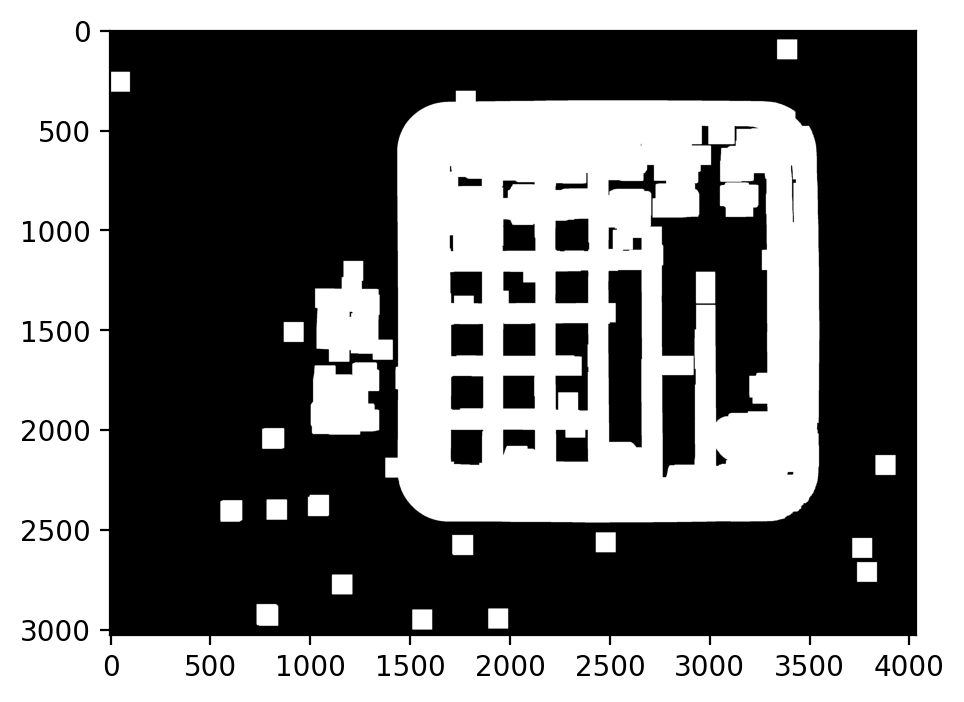

In [4]:
#This step is used to ensure any gaps around the plate contour are filled in
dilate = pcv.dilate(gray_img=edges, ksize = 39, i=2)

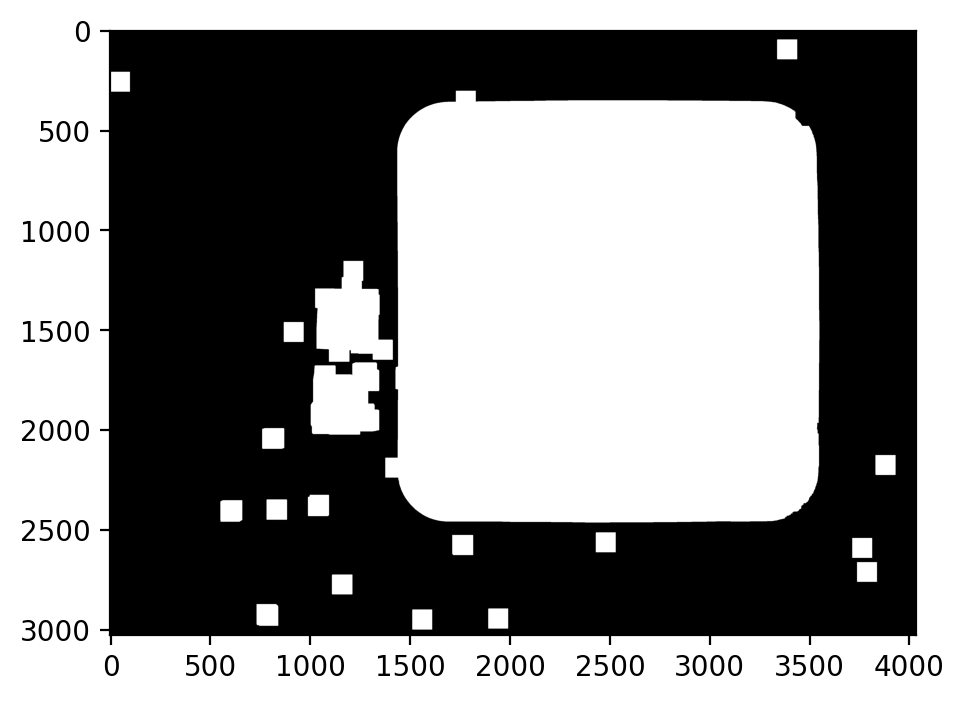

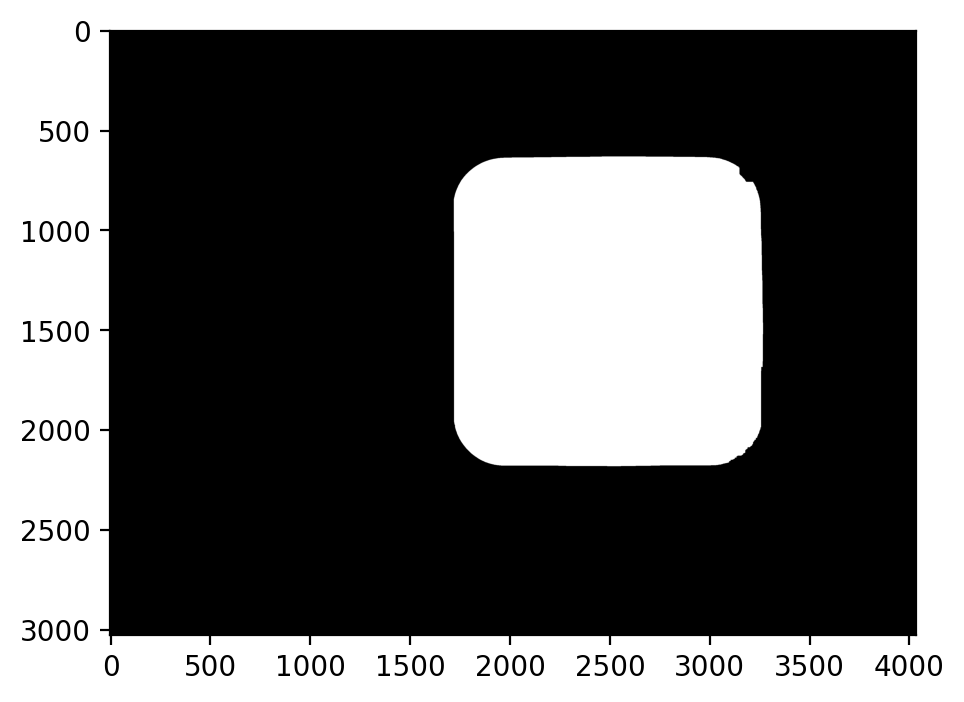

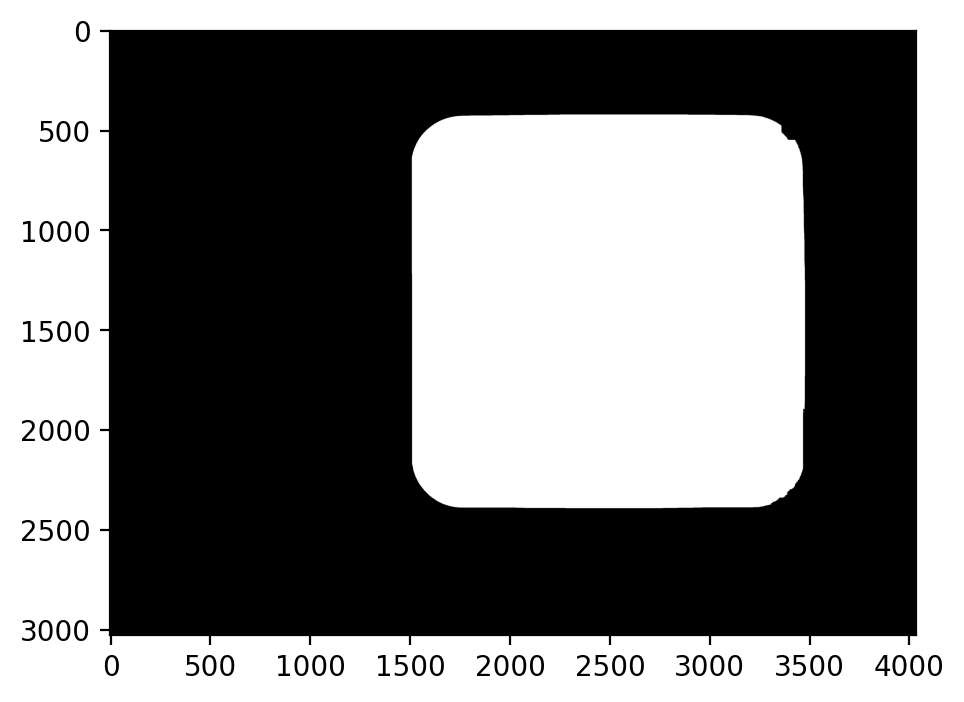

In [5]:
#These steps fill in the plate area and then remove noise by eroding and dilating
fill_image = pcv.fill_holes(bin_img=dilate)
#A large kernel size is used for these steps to remove everything except the plate which should be the largest object
erode = pcv.erode(gray_img=fill_image, ksize = 561, i=1)
dilate = pcv.dilate(gray_img=erode, ksize = 421, i=1)

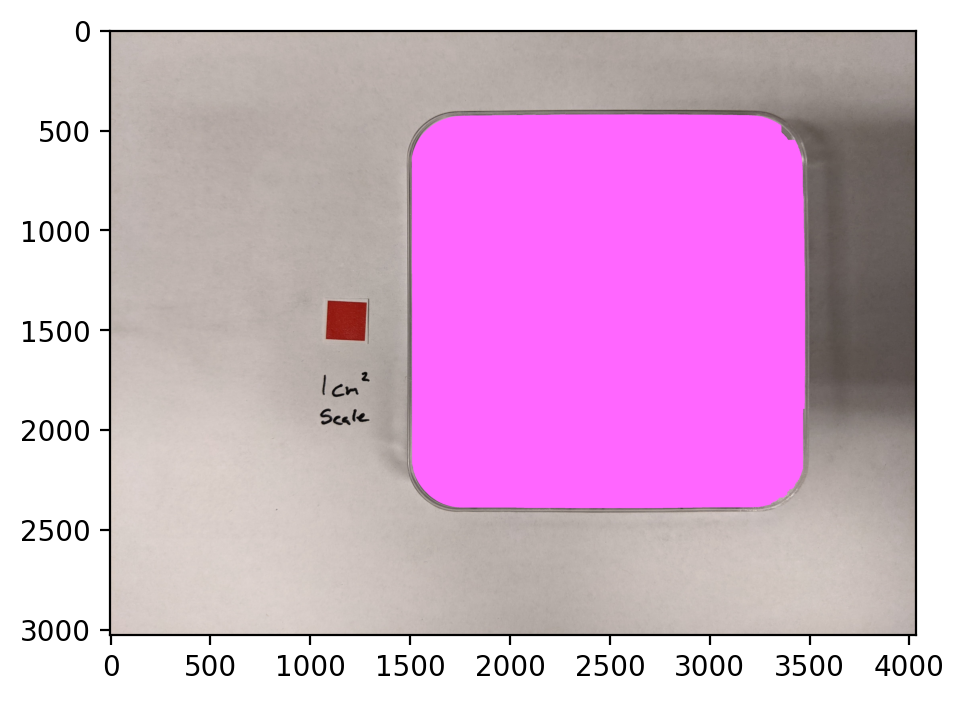

1


In [6]:
#after filtering steps there should only be one object visible and it should be the plate
id_objects, obj_hierarchy = pcv.find_objects(img=image, mask=dilate)
print(len(id_objects))

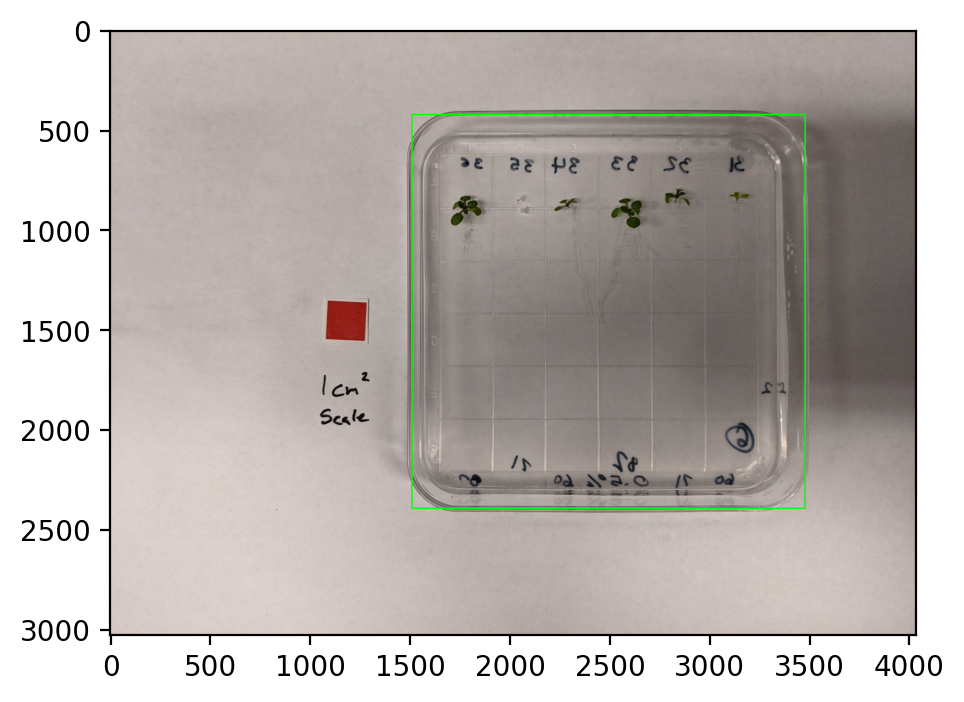

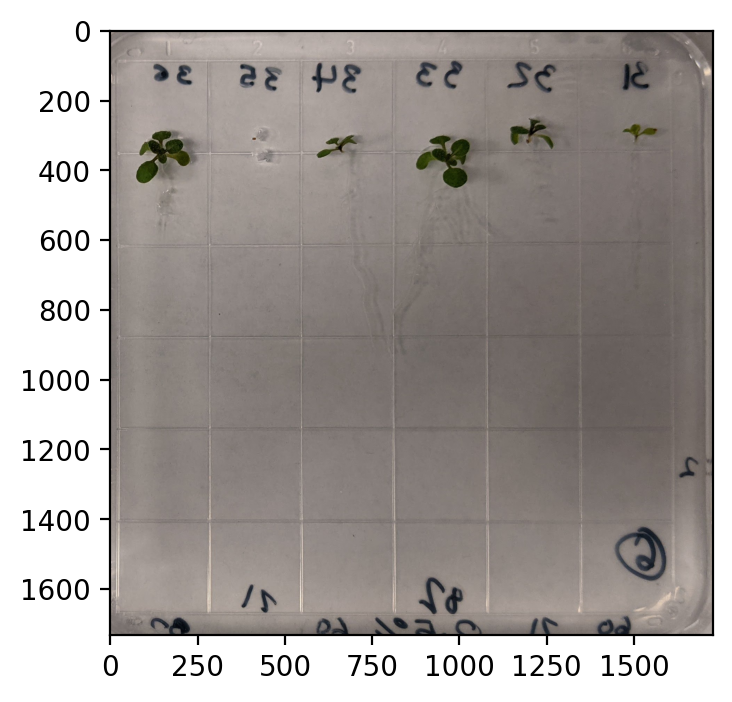

(1731, 1727, 3)


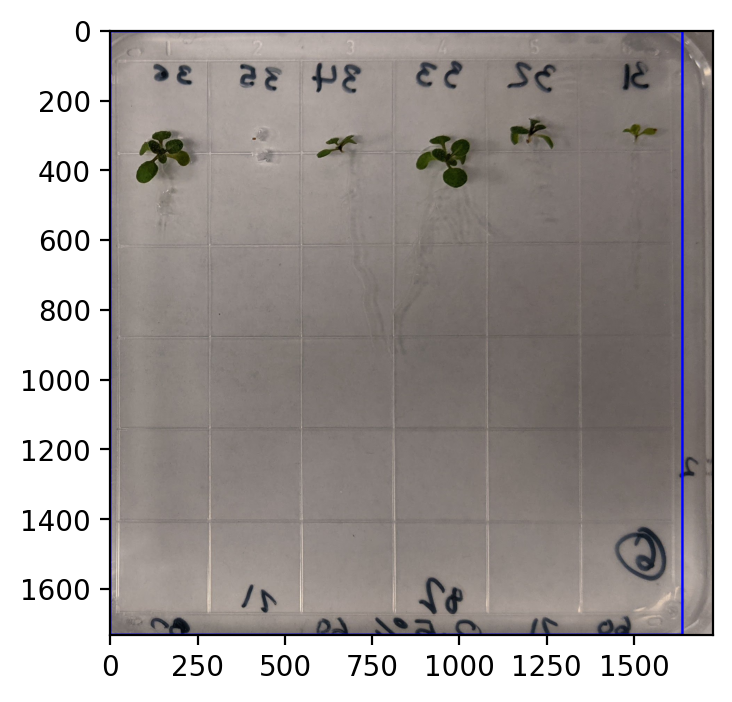

((2493.0, 1402.9998779296875), (1969.999755859375, 1965.999755859375), 90.0)


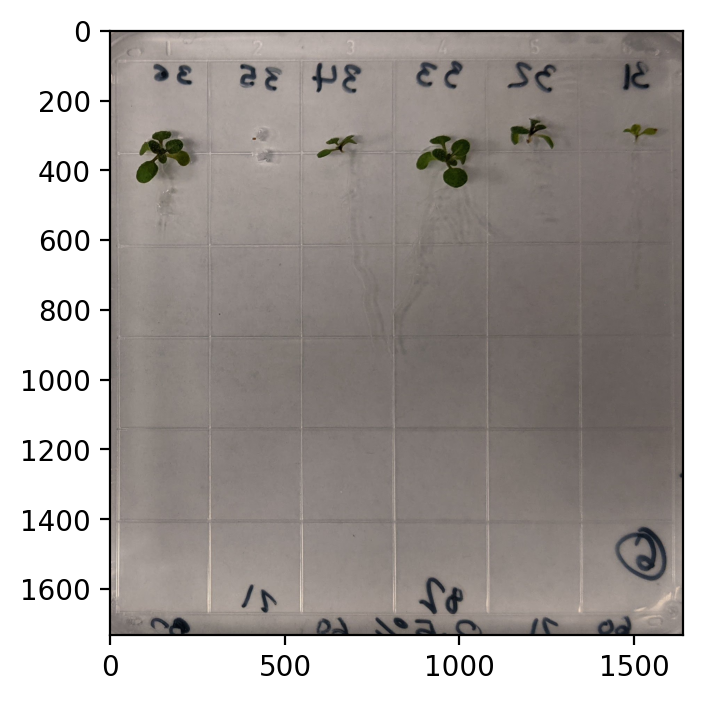

In [7]:
#These steps give us the size of the plate and then crop and rotat the image so only the plate area is showing and rotate it if needed
plate = id_objects[0]
x,y,w,h = cv2.boundingRect(plate)
plate_crop= pcv.auto_crop(img= image, obj=plate, padding_x=-120, padding_y=-120, color="image")
shape=plate_crop.shape
print(shape)
#this additional cropping step is specific to this image set which is photographed such that the right side of the plate rim is slightly longer
plate_crop = pcv.crop(img = plate_crop,x=0,y=0,h=shape[0], w=int(shape[1]*0.95))
#This gives the minimum rectange needed to enclose the object(the plate) and can therefore be used to determine how many pixels make up the plate
rect = cv2.minAreaRect(plate)
print(rect)
#since the plates are a standard size (10,000mm^2) we can use the number of pixels making up the plate to convert pixels to area
plate_px = rect[1][0]*rect[1][1]
pixels_per_mm2_plate = float(plate_px/10000)
box = cv2.boxPoints(rect)
box = np.int0(box)
#this rotates the plate image if it is needed
angle = rect[2]
if angle < 4.0 and angle > -4.0:
    plate_crop = pcv.transform.rotate(plate_crop, angle, False)
else: plate_crop = pcv.transform.rotate(plate_crop, angle-90, False)

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plantcv\plantcv\rgb2gray_cmyk.py:38: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plantcv\plantcv\rgb2gray_cmyk.py:41: RuntimeWarning: invalid value encountered in true_divide
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\plantcv\plantcv\rgb2gray_cmyk.py:44: RuntimeWarning: invalid value encountered in true_divide


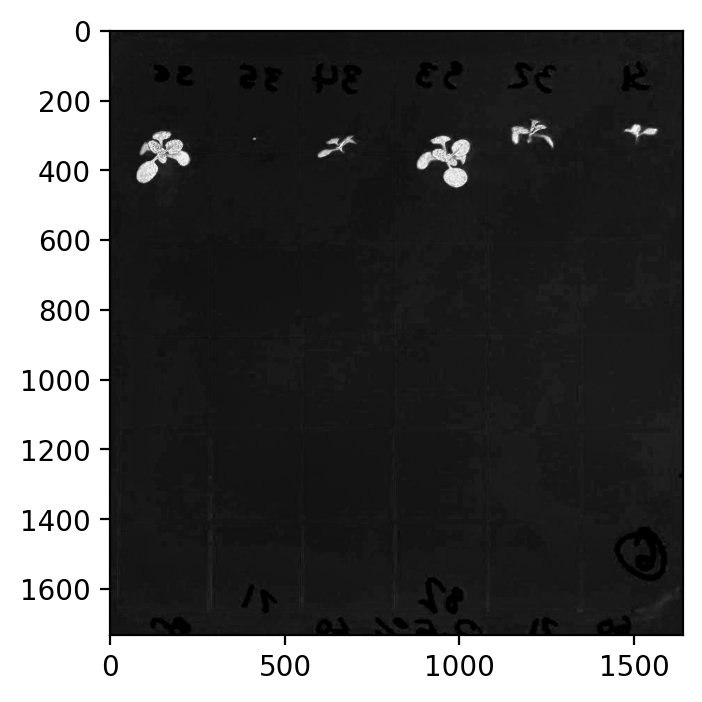

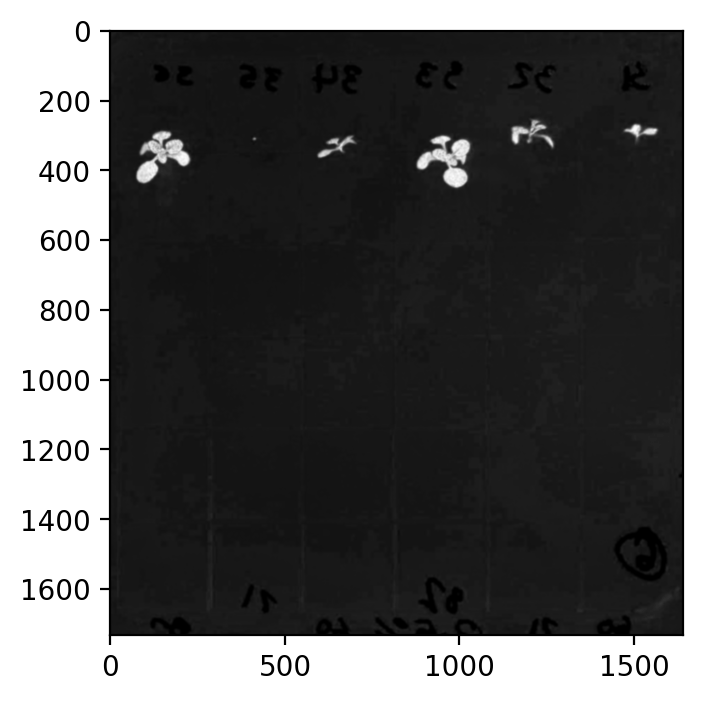

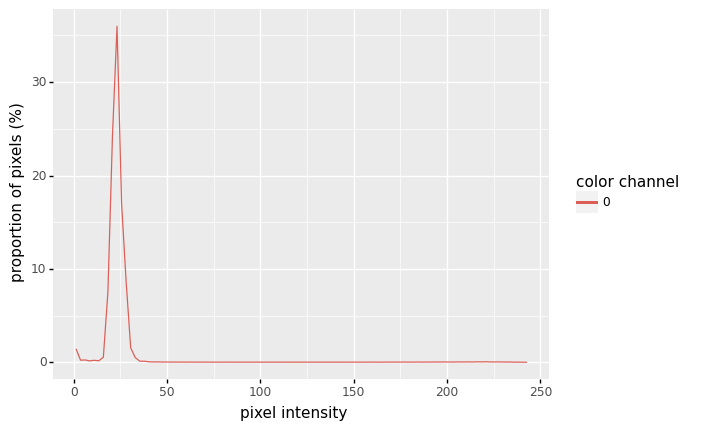

In [8]:
#Now that the image is cropped to only the plate area we can start identifying the rosettes
#For this image set the "c" channel of cmyk colorspace was used. Depending on the lighting and background conditions other channels from other colorspaces such as LAB better choices
img_bw = pcv.rgb2gray_cmyk(rgb_img=plate_crop, channel="c")
#A blur is needed to reduce noise
blur = pcv.gaussian_blur(img=img_bw, ksize=(13, 13), sigma_x=2, sigma_y=2)
#this function creates a histogram of the pixel intensities in the image. It is very useful for determining threshold values
hist_figure1, hist_data1 = pcv.visualize.histogram(blur, hist_data=True)

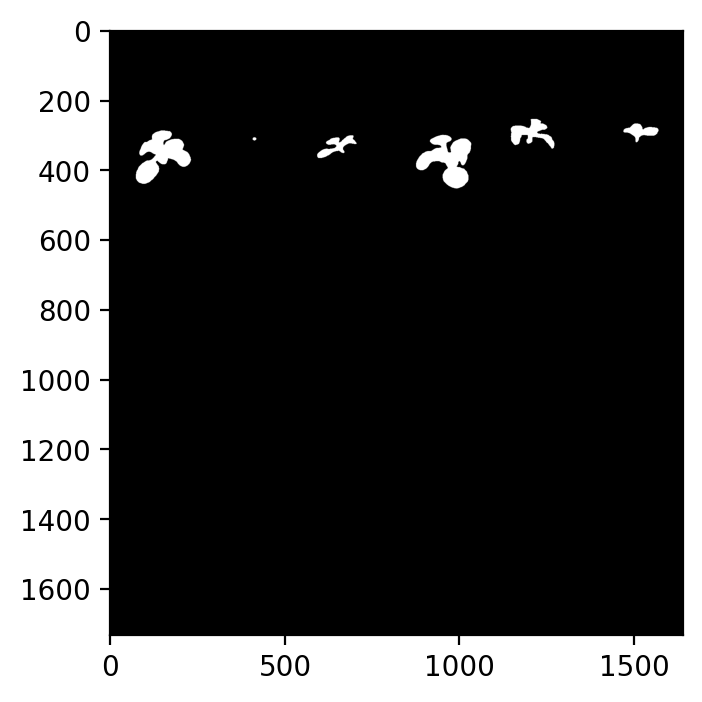

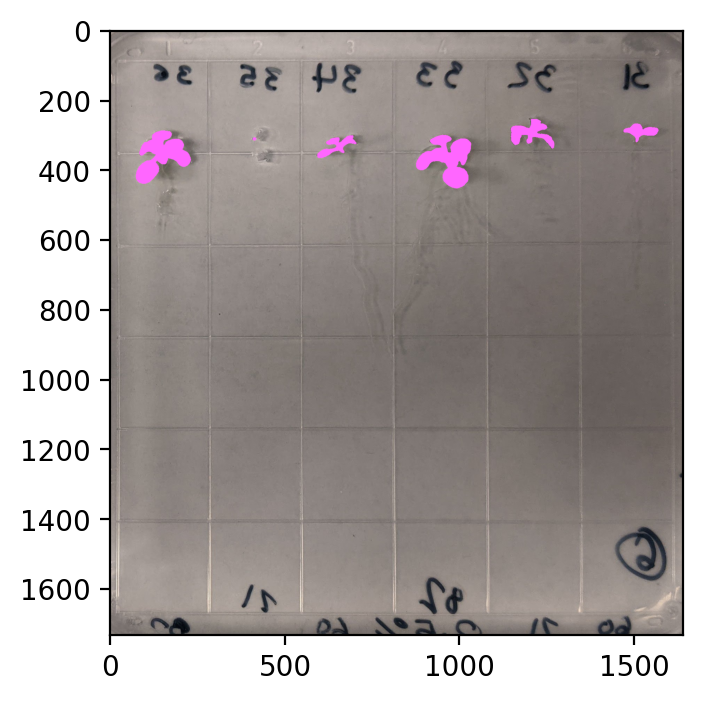

In [9]:
#Based on the histogram we chose 50 as an appropriate threshold value
#since this image set was taken with constant lighting and the contrast is fairly high no histogram normalization was needed.
#For an example where this is used see the dedicated scale demo.
thresh = pcv.threshold.binary(gray_img=blur, threshold=50, max_value=255, object_type="light")
#This identifies all objects within the binary image
id_objects, obj_hierarchy = pcv.find_objects(img=plate_crop, mask=thresh)

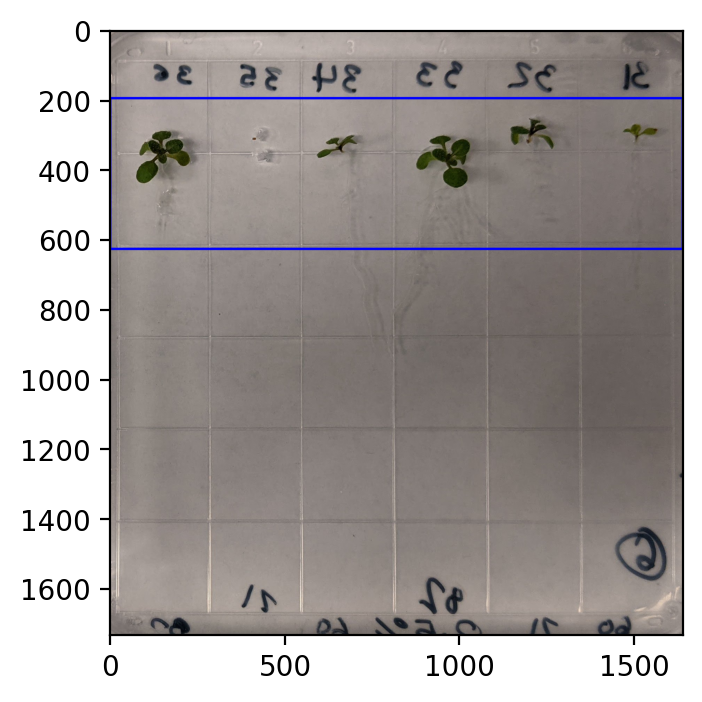

In [10]:
#these steps define the Region Of Interest (ROI)
#shape is the size of the cropped image shape[1] is the width and shape[0] is the height
shape = np.shape(plate_crop)
#For this image set the ROI begins 1/9 of the way down (vertically) from the top of the plate and is 1/4 of the plate long. It is as wide as the image
roi_contour, roi_hierarchy = pcv.roi.rectangle(img=plate_crop, x=0, y=shape[0]/9, h=shape[0]/4, w=shape[1])

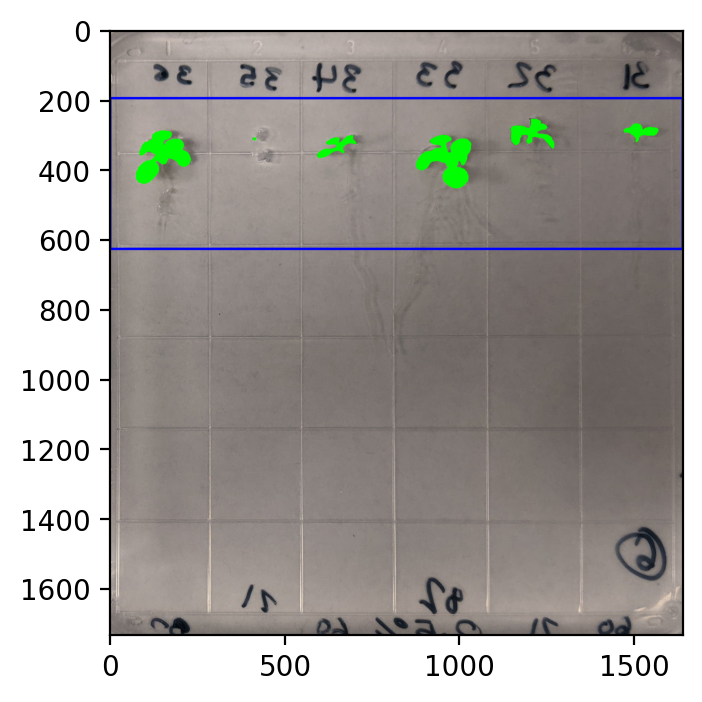

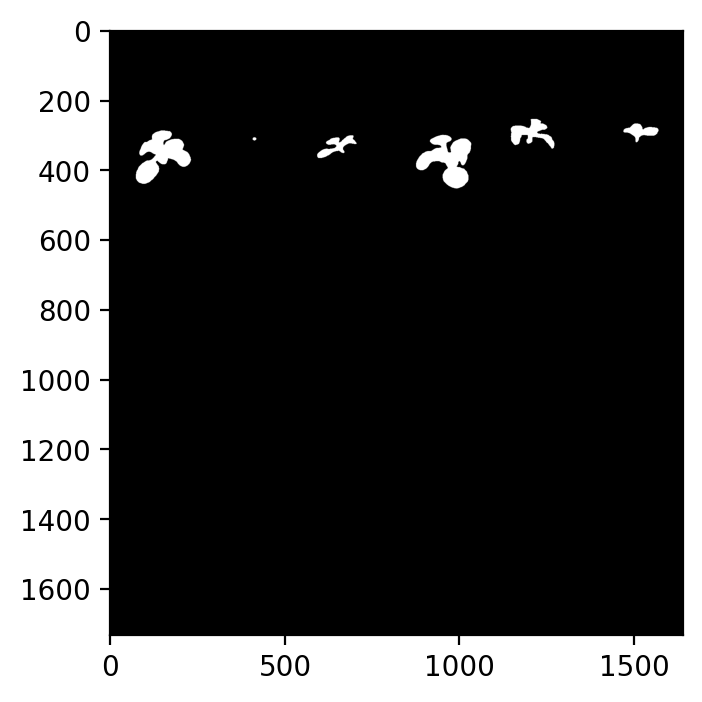

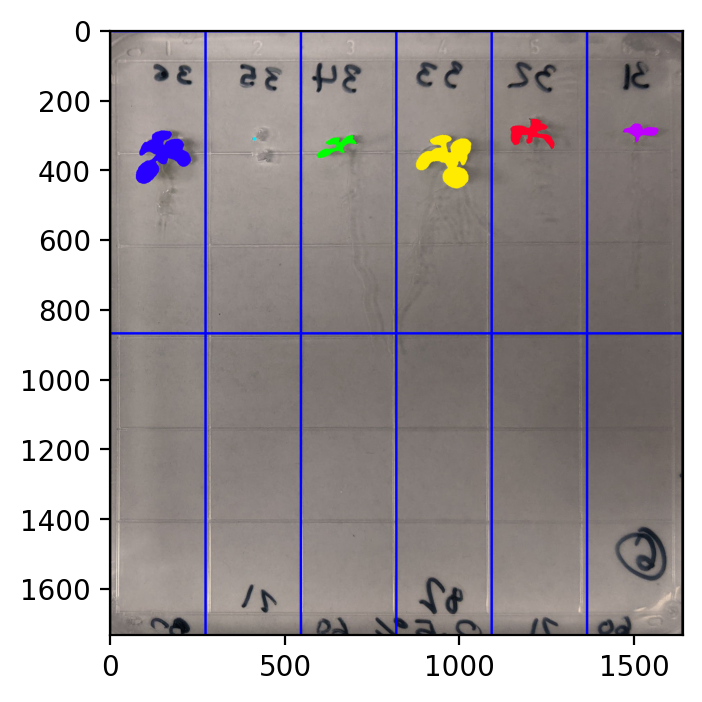

This function has been updated to include object hierarchy so object holes can be included


In [11]:
#Identifies all the objects within the defined region of interest
roi_objects, hierarchy, kept_mask, obj_area = pcv.roi_objects(img=plate_crop, 
                                                              roi_contour=roi_contour, roi_hierarchy=roi_hierarchy,
                                                              object_contour=id_objects, obj_hierarchy=obj_hierarchy, roi_type="partial")

#clustering defined leaves into individual plants using predefined rows/cols
#We are using a slightly modified version of the cluster contours function here (found in the file cluster_jordan.py)
clusters_i, contours, hierarchies = cluster_jordan.cluster_contours(img=plate_crop, roi_objects=roi_objects, 
                                                         roi_obj_hierarchy=hierarchy, nrow=2, ncol=6, show_grid=True)
#prevents extra debug images - change from None to "plot" to see all steps
pcv.params.debug = None
#splits the clusters into individual images for analysis
output_path, imgs, masks = cluster_jordan.cluster_contour_splitimg(rgb_img=plate_crop,
                                                        grouped_contour_indexes=clusters_i, contours=contours, 
                                                        hierarchy=hierarchies)

In [12]:
#cycles through the individual rosettes identified in the previous step and 
#calculates the image moment (number of pixels making up each rosette)
#it also looks for issues with leaf identification by comparing the number of pixels 
#found in the rosette to the minimum enclosing circle around the rosette. If the difference between the two
#is too large it flags the leaf as suspicious and prints a warning
sus = False
num_plants = 0
areas = {}

for i in range(0,6):
    pos = 7-(i+1)
    if clusters_i[i][0] != None:
        id_objects, obj_hierarchy = pcv.find_objects(img=imgs[num_plants], mask=masks[num_plants])
        obj, mask1 = pcv.object_composition(img=imgs[num_plants], contours=id_objects, hierarchy=obj_hierarchy)
        m = cv2.moments(obj)
        area = m['m00']
        num_plants += 1
        center, expect_r = cv2.minEnclosingCircle(obj)
        r = math.sqrt(area/math.pi)
        leaf_error = False
        if r <= 0.35*expect_r:
            leaf_error = True
            sus = True
            print(f"warning: there may be an error detecting leaf {pos}")

        areas[pos] = area
    else:
        areas[pos] = 0
print(areas)

{6: 11692.0, 5: 65.0, 4: 2670.0, 3: 12435.5, 2: 4676.5, 1: 2393.0}


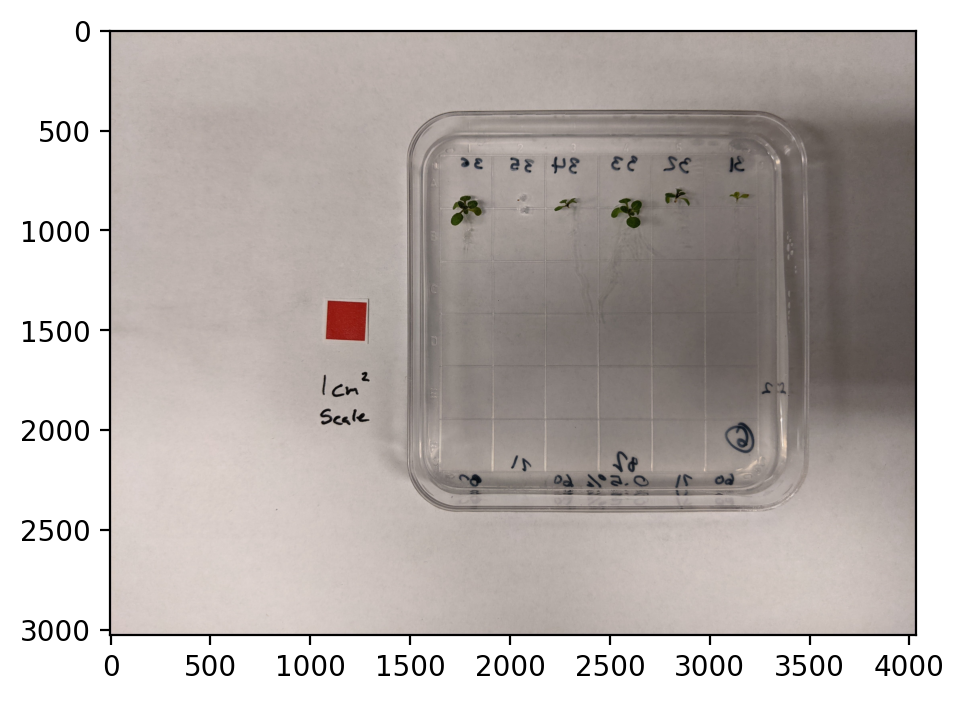

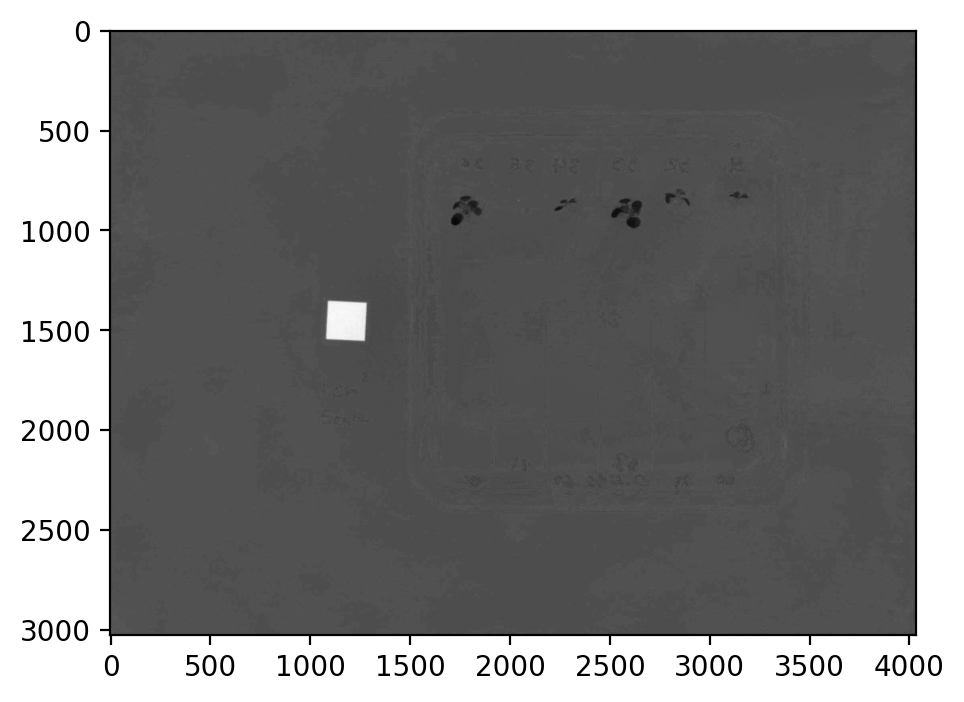

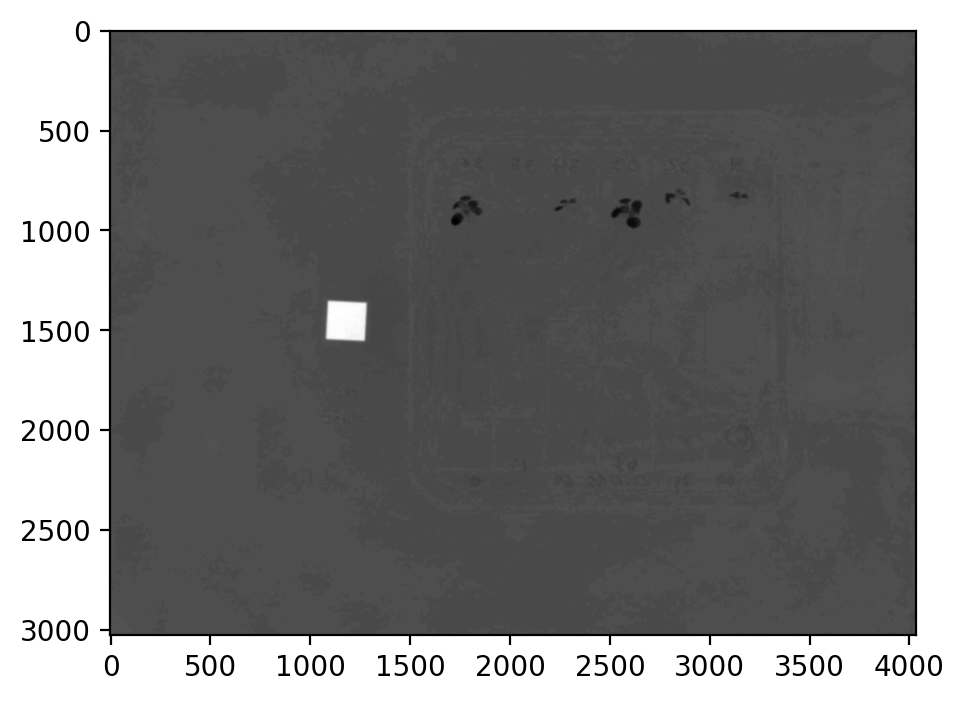

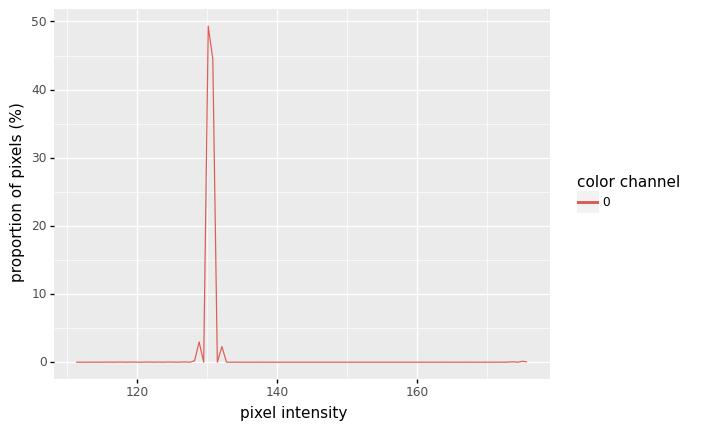

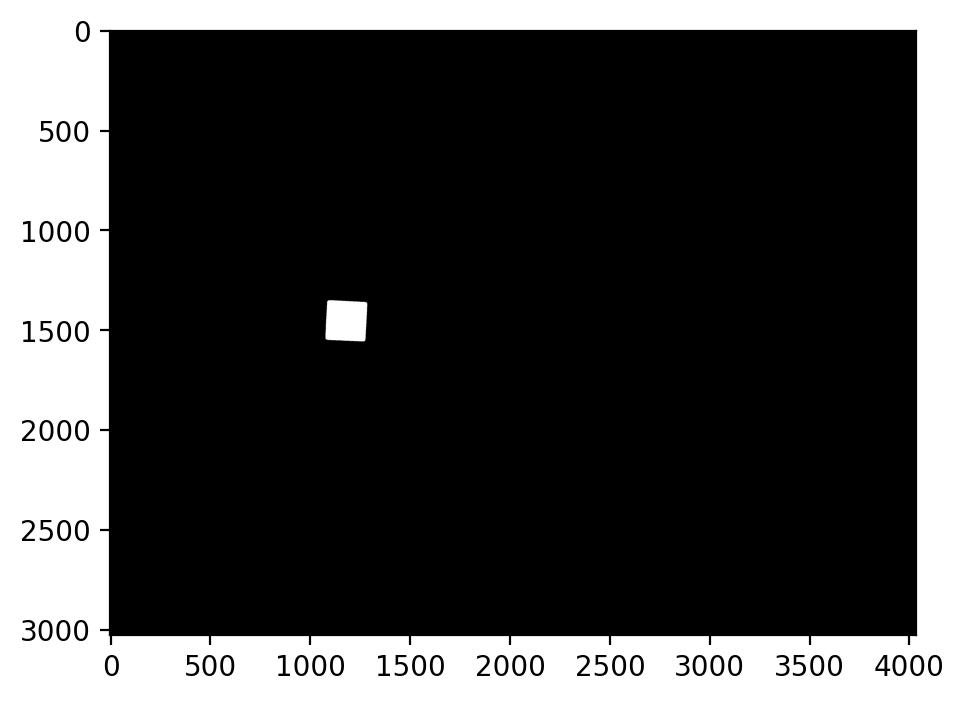

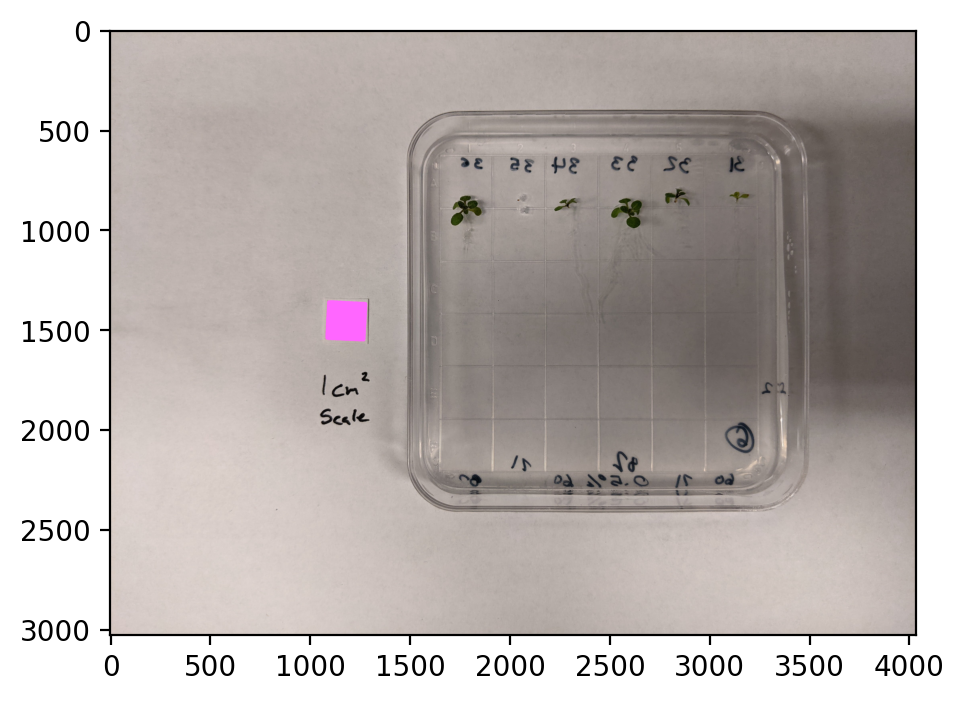

In [13]:
#These next steps show how the dedicated scale from this image was identified and also used to quantify leaf area
pcv.params.debug = "plot"
shape = image.shape
#The ROI for the dedicated scale is defined as the entire image - this works for this image set because the scale is easily seperated from the bacground
roi_contour_scale, roi_hierarchy_scale = pcv.roi.rectangle(img=image, x=0, y=0, h=shape[0], w=shape[1])
#The a channel of LAB color space is used to identify the scale
scale = pcv.rgb2gray_lab(rgb_img=image, channel="a")
scale = pcv.gaussian_blur(img=scale, ksize=(21, 21), sigma_x=None, sigma_y=None)
#again we use a histogram of pixel intensities in the channel of interest to determine the threshold.
hist_figure1, hist_data1 = pcv.visualize.histogram(scale, hist_data=True)
scale_thresh = pcv.threshold.binary(gray_img=scale, threshold=140, max_value=255, object_type="light")
id_scale, obj_hierarchy = pcv.find_objects(img=image, mask=scale_thresh)
#Additionall loop to determine if any noise in the image was detected as an object along with the scale. If there was it applies erosion and dilation to filter it out
if len(obj_hierarchy)>1:
    erode = pcv.erode(gray_img=scale_thresh, ksize = 20, i=1)
    dilate = pcv.dilate(gray_img=scale_thresh, ksize = 20, i=1)
    id_scale, obj_hierarchy = pcv.find_objects(img=image, mask=dilate)


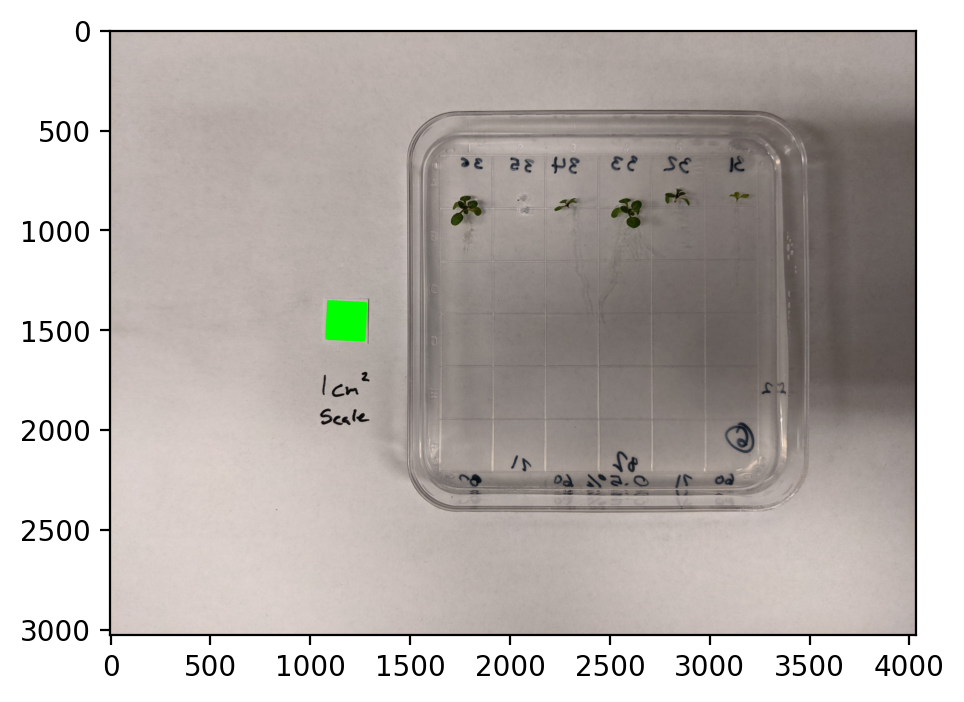

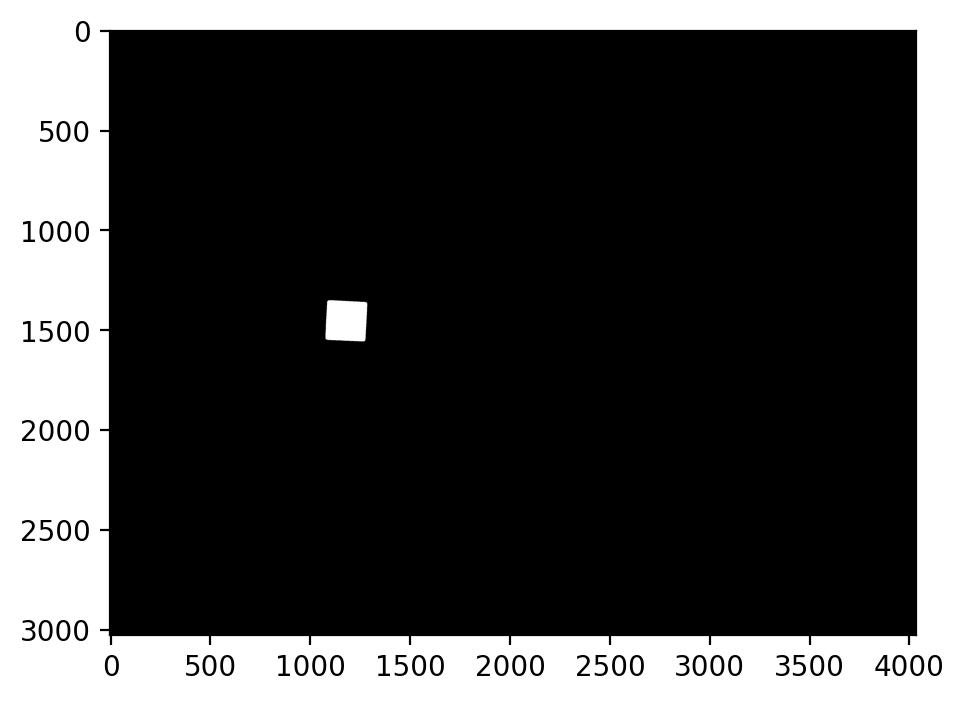

In [14]:
#detects all objects within the roi
roi_scale, scale_hierarchy, scale_mask, scale_area = pcv.roi_objects(img=image, 
                                                              roi_contour=roi_contour_scale, roi_hierarchy=roi_hierarchy_scale,
                                                                     object_contour=id_scale, obj_hierarchy=obj_hierarchy, roi_type="partial")
#there should only be one object so the first object in the list is the one we are looking for
object = roi_scale[0]
#Image moment is the number of pixels
m = cv2.moments(object)
scale_pixels = m['m00']
scale_area = 100  # mm2
pixels_per_mm2_scale = float(scale_pixels)/scale_area
#Now we have pixel to mm^2 conversions based on the plate itself and the dedicated scale. We can use either one of them to measure rosette area


In [ ]:
#first the raw pixel counts for each rosette
print("raw pixels")
print(areas)

converted_areas_scale = {}
conv_areas_plate = {}

#next we convert the pixel counts to mm^2 using the conversion factor calculated from the dedicated scale
for pos, area in areas.items():
    converted_areas_scale[pos] = area/pixels_per_mm2_scale
print("areas measured with red scale")
print(converted_areas_scale)


#finally we convert the pixel counts to mm^2 using the conversion factor calculated from the plate area
for pos, area in areas.items():
    conv_areas_plate[pos] = area/pixels_per_mm2_plate
print("areas mesured with plate")
print(conv_areas_plate)
    